
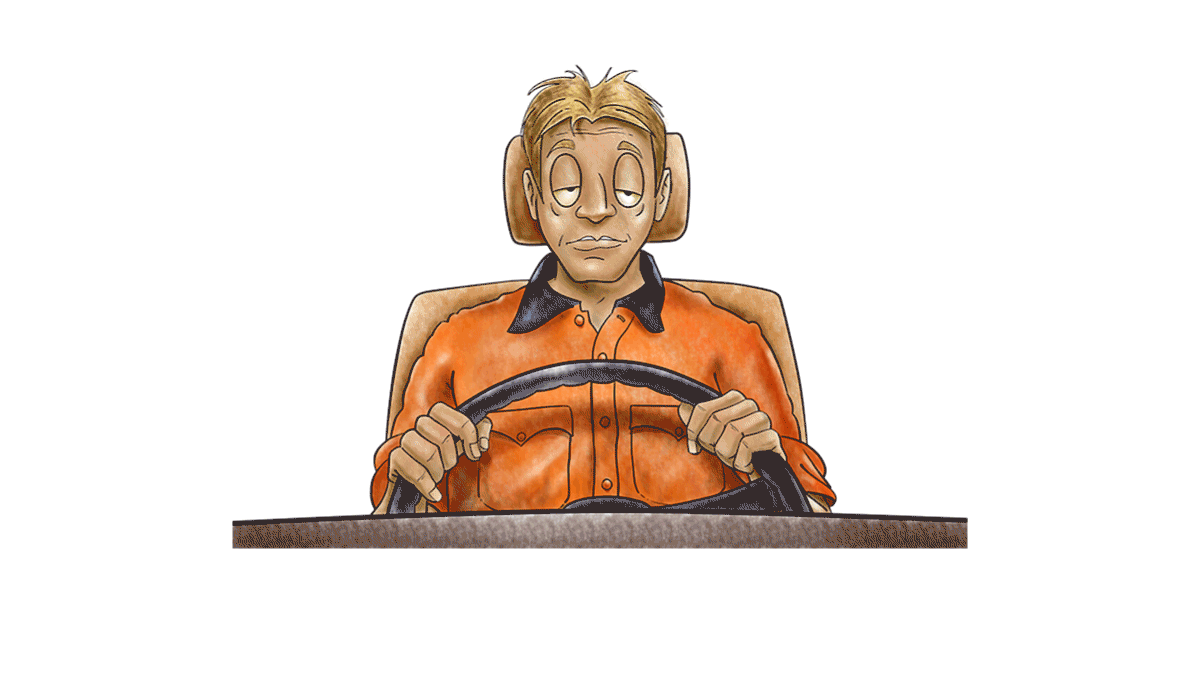
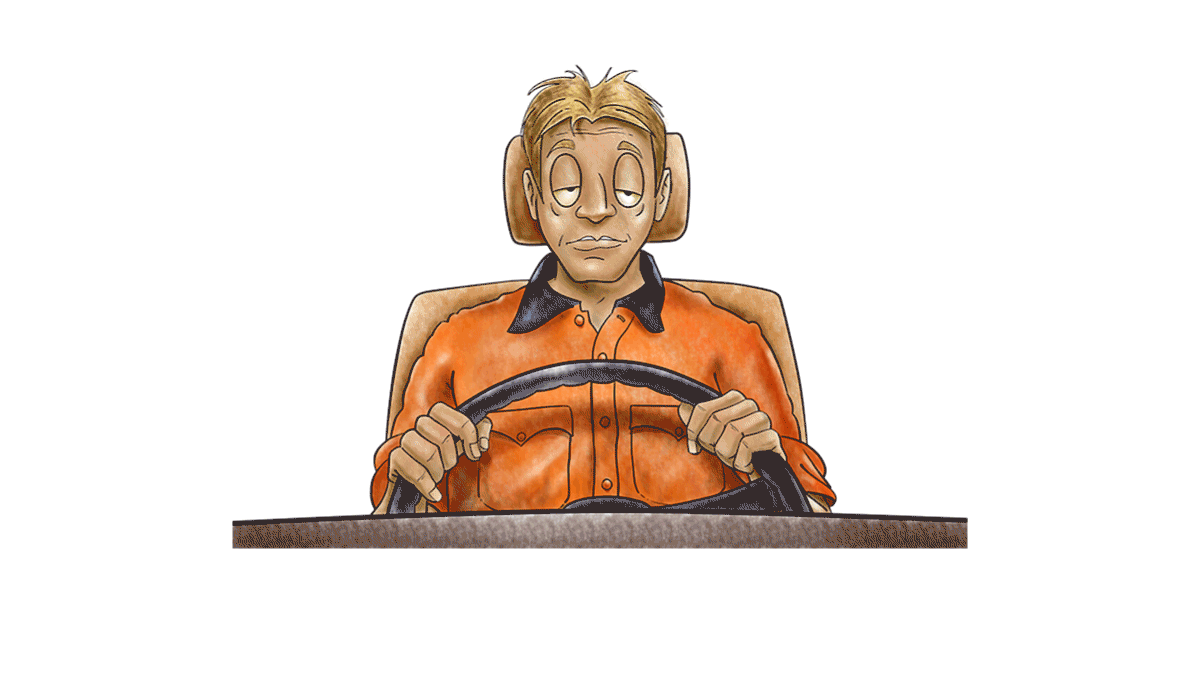

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os #to interact with the operating system
import cv2

# labels

In [4]:
labels = os.listdir("../input/drowsiness-dataset/train")

In [5]:
labels

['Closed', 'Open', 'yawn', 'no_yawn']

# visualize random 1 image

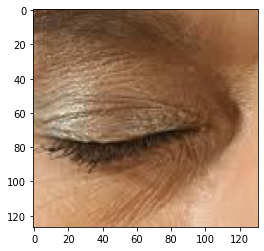

In [6]:
#closeEye
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Closed/_10.jpg"))

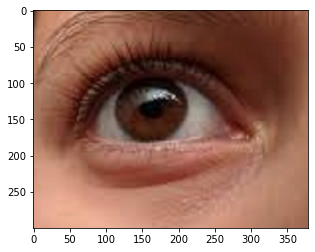

In [7]:
#openEye
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Open/_100.jpg"))

# image array

In [8]:
a = plt.imread("../input/drowsiness-dataset/train/yawn/10.jpg")

# image shape

In [9]:
a.shape

(480, 640, 3)

# visualize yawn image. 
# Here background is unnecessary. we need only face image array

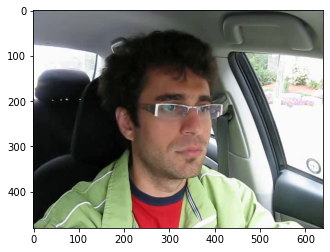

In [10]:
#no yawn
plt.imshow(plt.imread("../input/drowsiness-dataset/train/no_yawn/1028.jpg"))

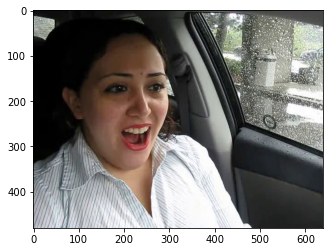

In [11]:
#yawn
plt.imshow(plt.imread("../input/drowsiness-dataset/train/yawn/104.jpg"))

# for yawn and not_yawn. Take only face

In [12]:
def face_for_yawn(direc="../input/drowsiness-dataset/train", face_cas_path="../input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR) #imread reads the image file n if the file is improper or not found then returns an empty matrix
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


# for closed and open eye

In [13]:
def get_data(dir_path="../input/drowsiness-dataset/train/", face_cas="../input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../input/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [14]:
data_train = get_data()

2
3


# extend data and convert array

In [15]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

# new variable to store

In [16]:
new_data = append_data()

0
1
2
3


# separate label and features

In [17]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# reshape the array

In [18]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# LabelBinarizer

In [19]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

# label array

In [20]:
y = np.array(y)

# train test split

In [21]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# length of X_test

In [22]:
len(X_test)

578

In [23]:
y_test

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

# Not necessary, only use to matching with my pc version

In [24]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

# import some dependencies

In [25]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# tensorflow version

In [26]:
tf.__version__

'2.3.0'

# keras version

In [27]:
import keras
keras.__version__

'2.4.3'

# Data Augmentation

In [28]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [29]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

In [31]:
history = model.fit(train_generator, epochs=5, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/5
43/43 [==============================] - 186s 4s/step - loss: 1.0412 - accuracy: 0.5590 - val_loss: 0.4942 - val_accuracy: 0.8028
Epoch 2/5
43/43 [==============================] - 187s 4s/step - loss: 0.4461 - accuracy: 0.8233 - val_loss: 0.3656 - val_accuracy: 0.8218
Epoch 3/5
43/43 [==============================] - 187s 4s/step - loss: 0.3737 - accuracy: 0.8374 - val_loss: 0.3035 - val_accuracy: 0.8893
Epoch 4/5
43/43 [==============================] - 196s 5s/step - loss: 0.3436 - accuracy: 0.8508 - val_loss: 0.2998 - val_accuracy: 0.8737
Epoch 5/5
43/43 [==============================] - 185s 4s/step - loss: 0.2964 - accuracy: 0.8775 - val_loss: 0.3142 - val_accuracy: 0.8270


# history

Epoch 1/5
15/15 [==============================] - 57s 4s/step - loss: 3.5550 - accuracy: 0.7576 - val_loss: 0.7560 - val_accuracy: 0.7931
Epoch 2/5
15/15 [==============================] - 56s 4s/step - loss: 1.2142 - accuracy: 0.6970 - val_loss: 1.1402 - val_accuracy: 0.6897
Epoch 3/5
15/15 [==============================] - 57s 4s/step - loss: 1.1361 - accuracy: 0.5563 - val_loss: 1.5234 - val_accuracy: 0.4828
Epoch 4/5
15/15 [==============================] - 57s 4s/step - loss: 0.8812 - accuracy: 0.7338 - val_loss: 0.7150 - val_accuracy: 0.8190
Epoch 5/5
15/15 [==============================] - 57s 4s/step - loss: 0.7554 - accuracy: 0.7532 - val_loss: 0.6963 - val_accuracy: 0.8276


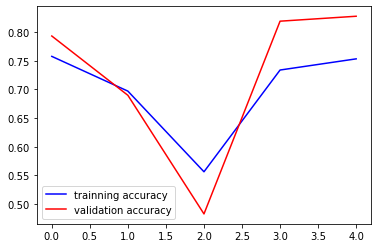

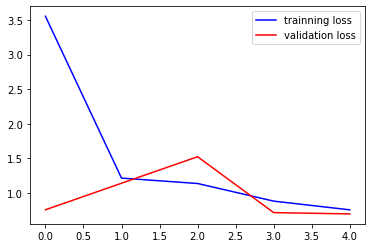

In [33]:
history = model.fit(X_test, y_test, epochs=5, validation_split=0.2, shuffle=True)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [34]:
model.save("drowiness_new6.h5")

In [35]:
model.save("drowiness_new6.model")

# Prediction

In [36]:
prediction = model.predict_classes(X_test)

In [37]:
prediction=prediction.reshape(-1,1)

In [38]:
prediction.shape

(578, 1)

In [39]:
type(prediction)

numpy.ndarray

In [40]:
import numpy as np

n_values = np.max(prediction) + 1
pred=np.eye(n_values)[prediction]
pred

array([[[0., 0., 1., 0.]],

       [[0., 0., 0., 1.]],

       [[0., 0., 1., 0.]],

       ...,

       [[0., 0., 0., 1.]],

       [[0., 0., 1., 0.]],

       [[0., 0., 1., 0.]]])

In [41]:
print(y_test.shape)
print(pred.shape)
pred=np.reshape(pred, (578*1, 4))
pred

(578, 4)
(578, 1, 4)


array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [42]:
from sklearn.metrics import confusion_matrix,accuracy_score

#Generate the confusion matrix
cf_matrix=confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
print(cf_matrix)
print(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))



[[ 38  23   2   0]
 [  4  59  11   0]
 [  2   5 204   4]
 [  1   0  48 177]]
0.8269896193771626


[Text(0, 0.5, 'yawn'),
 Text(0, 1.5, 'no_yawn'),
 Text(0, 2.5, 'Closed'),
 Text(0, 3.5, 'Open')]

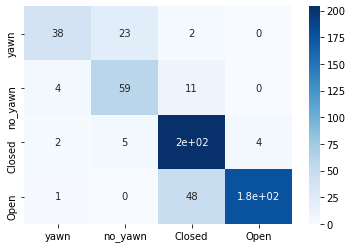

In [43]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels(['yawn','no_yawn','Closed','Open'])
ax.yaxis.set_ticklabels(['yawn','no_yawn','Closed','Open'])

# classification report

In [44]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [45]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.84      0.60      0.70        63
     no_yawn       0.68      0.80      0.73        74
      Closed       0.77      0.95      0.85       215
        Open       0.98      0.78      0.87       226

    accuracy                           0.83       578
   macro avg       0.82      0.78      0.79       578
weighted avg       0.85      0.83      0.83       578



# predicting function

In [46]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [47]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("../input/drowsiness-dataset/train/no_yawn/1067.jpg")])
np.argmax(prediction)

2

In [48]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/Closed/_101.jpg")])
np.argmax(prediction)

2

In [49]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/Open/_104.jpg")])
np.argmax(prediction)

3

In [50]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/yawn/113.jpg")])
np.argmax(prediction)

0